In [17]:
import pandas as pd
from pathlib import Path
import numpy as np 
import sys
sys.path.insert(0, "..")   
from src.cluster_util import cluster_data
from src.BinaryTriFactorizationEstimator import BinaryTriFactorizationEstimator
from src.BinaryTriFactorizationEstimator import  get_normalized_assignments, explain_coverage
from src.BinaryTriFactorizationEstimator import merge_blocks_by_stat
from src.data_utils import generate_growth_rate_features, normalize_data, collapse_block_id_by_store_item
from src.plot_util import plot_block_annot_heatmap


In [18]:
%reload_ext autoreload
%autoreload 2

In [19]:
%pwd

'/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook'

In [4]:
df = pd.read_parquet("../output/data/train_2014_January_12_store_20_item_cluster.parquet")
cols = [
        "date",
        "store_item",
        "store",
        "item",
        "store_cluster",
        "item_cluster",
        "weight",
        "onpromotion",
        "unit_sales"
    ]
df = df[cols]
df['store_item'] = df['store_item'].astype(str)
df.sort_values(["date", "store_item"], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,date,store_item,store,item,store_cluster,item_cluster,weight,onpromotion,unit_sales
0,2014-01-01,1_1047679,1,1047679,8,1,1,False,0.0
1,2014-01-01,1_1168718,1,1168718,8,0,1,False,0.0
2,2014-01-01,1_1463591,1,1463591,8,0,1,False,0.0
3,2014-01-01,1_1463992,1,1463992,8,4,1,False,0.0
4,2014-01-01,1_1464092,1,1464092,8,5,1,False,0.0


In [5]:
df.tail(10)

,date,store_item,store,item,store_cluster,item_cluster,weight,onpromotion,unit_sales
7430,2014-01-31,47_1695978,47,1695978,1,5,1,False,8.206
7431,2014-01-31,47_401911,47,401911,1,0,1,False,10.000
7432,2014-01-31,47_557286,47,557286,1,0,1,False,5.000
7433,2014-01-31,47_567781,47,567781,1,0,1,False,18.000
7434,2014-01-31,47_587069,47,587069,1,0,1,False,0.000
7435,2014-01-31,47_671076,47,671076,1,1,1,False,6.000
7436,2014-01-31,47_807493,47,807493,1,6,1,False,118.000
7437,2014-01-31,47_850542,47,850542,1,0,1,False,0.000
7438,2014-01-31,47_864508,47,864508,1,0,1,False,0.000
7439,2014-01-31,47_864510,47,864510,1,0,1,False,0.000


In [6]:
df.describe()

,date,store,item,weight,unit_sales
count,7440,7440.000000,7.440000e+03,7440.0,7440.000000
mean,2014-01-16 00:00:00,30.166667,1.114622e+06,1.0,37.897305
min,2014-01-01 00:00:00,1.000000,4.019110e+05,1.0,0.000000
25%,2014-01-08 00:00:00,27.500000,7.733888e+05,1.0,0.000000
50%,2014-01-16 00:00:00,31.500000,1.108198e+06,1.0,0.000000
75%,2014-01-24 00:00:00,41.000000,1.480885e+06,1.0,9.000000
max,2014-01-31 00:00:00,47.000000,1.695978e+06,1.0,1273.188965
std,NaN,14.230230,4.265349e+05,0.0,117.650421


In [7]:
output_path = Path("../output/data/growth_rate_features.csv")
generate_growth_rate_features(df, window_size=1, calendar_aligned=True, 
                              log_level="DEBUG",
                              output_path=output_path,
                            )


2025-09-03 12:54:29,169 - INFO - Total rows: 7440


2025-09-03 12:54:29,281 - INFO - Processing window: 2014-01-01 00:00:00 to 2014-01-01 00:00:00
2025-09-03 12:54:29,565 - INFO - Processing window: 2014-01-02 00:00:00 to 2014-01-02 00:00:00
2025-09-03 12:54:29,834 - INFO - Processing window: 2014-01-03 00:00:00 to 2014-01-03 00:00:00
2025-09-03 12:54:30,102 - INFO - Processing window: 2014-01-04 00:00:00 to 2014-01-04 00:00:00
2025-09-03 12:54:30,386 - INFO - Processing window: 2014-01-05 00:00:00 to 2014-01-05 00:00:00
2025-09-03 12:54:30,664 - INFO - Processing window: 2014-01-06 00:00:00 to 2014-01-06 00:00:00
2025-09-03 12:54:30,932 - INFO - Processing window: 2014-01-07 00:00:00 to 2014-01-07 00:00:00
2025-09-03 12:54:31,195 - INFO - Processing window: 2014-01-08 00:00:00 to 2014-01-08 00:00:00
2025-09-03 12:54:31,463 - INFO - Processing window: 2014-01-09 00:00:00 to 2014-01-09 00:00:00
2025-09-03 12:54:31,750 - INFO - Processing window: 2014-01-10 00:00:00 to 2014-01-10 00:00:00
2025-09-03 12:54:32,057 - INFO - Processing window

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1
0,2014-01-01,1_401911,1,401911,1,0.000000,NaN,0
1,2014-01-01,1_557286,1,557286,1,0.000000,NaN,0
2,2014-01-01,1_567781,1,567781,1,0.000000,NaN,0
3,2014-01-01,1_587069,1,587069,1,0.000000,NaN,0
4,2014-01-01,1_671076,1,671076,1,0.000000,NaN,0
...,...,...,...,...,...,...,...,...
7435,2014-01-31,47_1503117,47,1503117,1,0.000000,NaN,0
7436,2014-01-31,47_1503844,47,1503844,1,319.608002,18.450544,0
7437,2014-01-31,47_1639937,47,1639937,1,0.000000,NaN,0
7438,2014-01-31,47_1695835,47,1695835,1,106.293999,-39.836425,0


In [20]:
df = pd.read_csv("../output/data/growth_rate_features.csv")
df.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0


In [21]:
# Build normalized + raw matrices
norm_data = normalize_data(
        df,
        column_name="growth_rate_1", 
        log_transform=False, 
        median_transform=False, 
        mean_transform=True,
        zscore_rows=False,
        zscore_cols=True,
).fillna(0)

/Users/yvesgreatti/github/kaggle_favorita_grocery_sales_forecasting/notebook/../src/data_utils.py:1457: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(values, axis=axis, keepdims=True)
/Users/yvesgreatti/.pyenv/versions/retail/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [22]:
est = BinaryTriFactorizationEstimator(
    n_row_clusters=4,         # try a few values (e.g., 3–8)
    n_col_clusters=5,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.6,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=50,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(norm_data.to_numpy())


In [23]:
assign = est.filter_blocks(X= norm_data.to_numpy(), min_keep=6)

In [24]:
norm_data2 = normalize_data(
        df,
        column_name="growth_rate_1", 
        log_transform=False, 
        median_transform=False, 
        mean_transform=True,
        zscore_rows=False,
        zscore_cols=False,
).fillna(0)

In [25]:
norm_data2

item,401911,557286,567781,587069,671076,807493,850542,864508,864510,1047679,1168718,1463591,1463992,1464092,1473474,1503117,1503844,1639937,1695835,1695978
store,,,,,,,,,,,,,,,,,,,,
1,-71.428571,15.000000,-8.823529,0.0,-40.625000,32.144711,0.0,0.0,0.0,34.862597,-31.250000,39.050926,30.829266,0.000000,20.857863,0.0,14.154704,0.0,14.415022,0.000000
3,-2.631579,-0.484857,47.853038,0.0,40.105820,9.477816,0.0,0.0,0.0,2.667489,-34.166667,25.541702,7.333104,86.063237,3.778021,0.0,10.429606,0.0,5.383529,24.039878
26,-21.515152,-63.636364,7.878788,0.0,-6.884058,55.144351,0.0,0.0,0.0,85.827763,27.711111,-66.666667,70.983929,128.978283,26.717283,0.0,94.031430,0.0,15.586832,27.307407
28,-3.439153,5.434783,31.309524,0.0,3.730159,20.686374,0.0,0.0,0.0,90.928433,-11.284848,-29.513889,172.009322,33.714064,16.232130,0.0,0.000000,0.0,33.258995,0.000000
30,-66.666667,0.000000,0.000000,0.0,5.555556,123.990015,0.0,0.0,0.0,50.060691,-25.438596,0.000000,72.126217,-25.000000,9.060922,0.0,0.000000,0.0,0.000000,0.000000
31,8.066667,-14.444444,-1.587302,0.0,13.188406,17.569627,0.0,0.0,0.0,217.898102,-7.142857,0.000000,31.622362,-11.111111,52.686136,0.0,137.769360,0.0,0.000000,0.000000
32,-66.666667,0.000000,0.000000,0.0,-30.952381,136.649605,0.0,0.0,0.0,20.000000,37.465278,0.000000,17.061494,-8.333333,0.000000,0.0,0.000000,0.0,0.000000,0.000000
35,-22.727273,0.000000,0.000000,0.0,-69.642857,120.239878,0.0,0.0,0.0,181.506355,-32.456140,0.000000,185.565163,-3.125000,30.141348,0.0,0.000000,0.0,0.000000,0.000000
40,46.494709,0.000000,0.000000,0.0,23.321142,18.638571,0.0,0.0,0.0,47.954120,34.474548,0.000000,10.969167,543.362621,5.216858,0.0,0.000000,0.0,0.000000,0.000000


In [26]:
df2 = get_normalized_assignments(assign, norm_data2)

In [27]:
df2.head()

,store,item,growth_rate_1,block_id
0,1,401911,-71.428571,8
1,1,557286,15.000000,4
2,1,567781,-8.823529,9
3,1,587069,0.000000,4
4,1,671076,-40.625000,9


2025-09-03 14:23:04,554 - INFO - Saving plot to ../output/figures/store_item_Jan_2014_heatmap.tiff


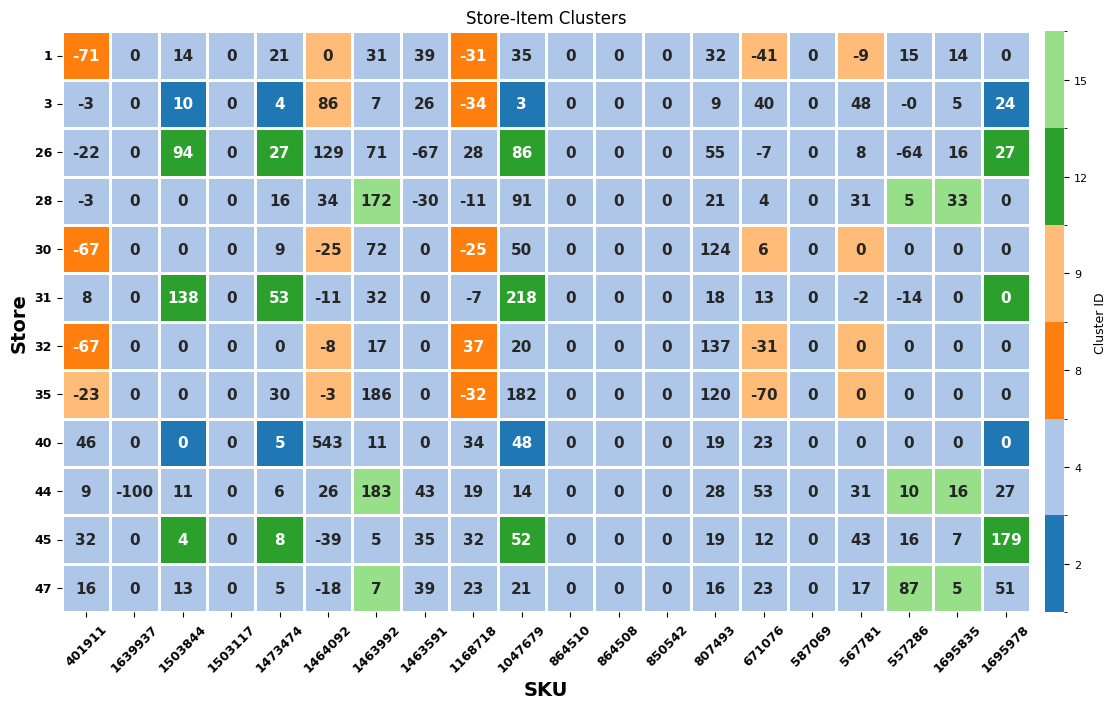

In [28]:
row_order, col_order = est.get_row_col_orders(assign, norm_data2)
fn = Path("../output/figures/store_item_Jan_2014_heatmap.tiff")
# plot (no dates in this table)
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)

In [17]:
summary = est.explain_blocks(
    X=norm_data2.to_numpy(),
    assign=assign,               # <-- dict with block_id matrix
    row_names=norm_data2.index.to_numpy(),
    col_names=norm_data2.columns.to_numpy(),
    top_k=5,
)
summary


,block_id,r,c,B_rc,n_cells,coverage_%,mean,median,stores_in_r,items_in_c
1,4,0,4,1.216837,189,78.750000,14.971257,0.000000,"[3, 40]","[401911, 567781, 671076, 1464092]"
4,12,2,2,0.705519,12,5.000000,73.737111,52.351386,"[26, 31, 45]","[1047679, 1473474, 1503844, 1695978]"
5,15,3,0,0.619445,9,3.750000,57.539447,15.917028,"[28, 44, 47]","[557286, 1463992, 1695835]"
0,2,0,2,-0.470107,8,3.333333,11.760747,4.497439,"[3, 40]","[1047679, 1473474, 1503844, 1695978]"
3,9,1,4,-0.532300,14,5.833333,-8.400756,-5.729167,"[1, 3, 30, 32, 35]","[401911, 567781, 671076, 1464092]"
2,8,1,3,-0.690169,8,3.333333,-36.326004,-33.311404,"[1, 3, 30, 32, 35]","[401911, 1168718]"


In [18]:
explain_coverage(est, assign)

,c0,c1,c2,c3,c4
r0,0,0,8,0,189
r1,0,0,0,8,14
r2,0,0,12,0,0
r3,9,0,0,0,0


In [33]:
df2 = merge_blocks_by_stat(assign, df,norm_data2, est, stat="mean", scheme="kmeans", k=5)

In [34]:
df2.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,2
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,1
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,2
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,1


In [35]:
df2.block_id.unique()

array([0, 2, 1, 4, 3])

In [36]:
df2 = collapse_block_id_by_store_item(df2, how="mean")   
row_order, col_order = est.get_row_col_orders(assign, norm_data2)


2025-09-03 12:57:04,769 - INFO - Saving plot to ../output/figures/store_item_Jan_2014_mean_aggregated_heatmap.tiff


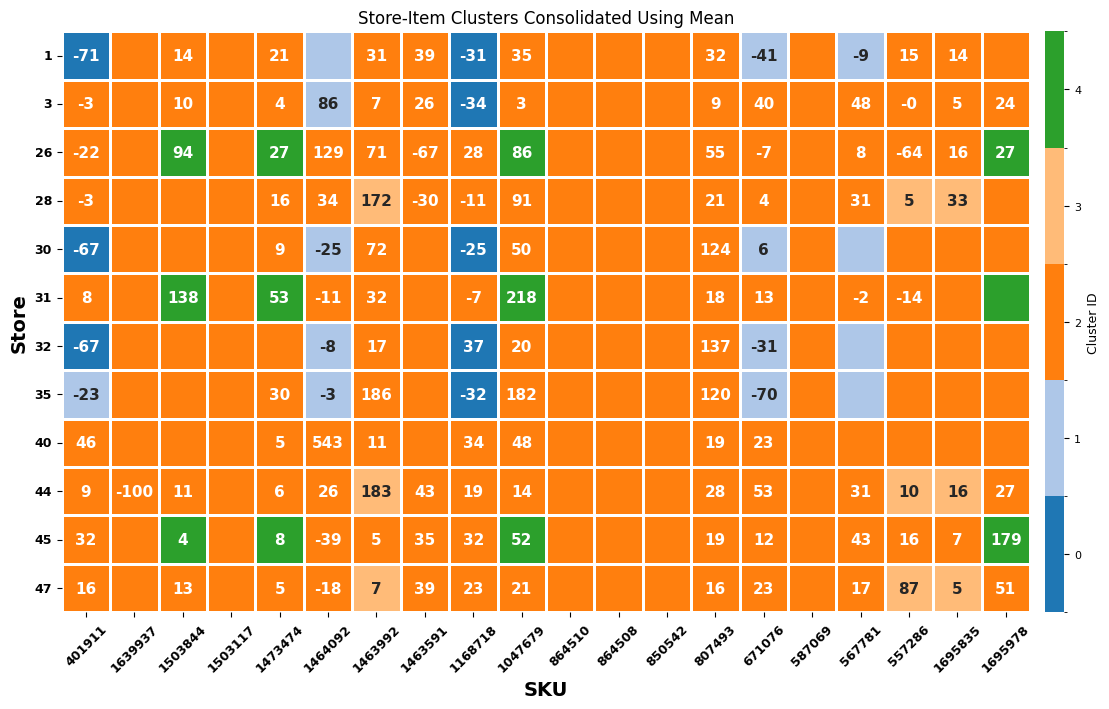

In [37]:
fn = Path("../output/figures/store_item_Jan_2014_mean_aggregated_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters Consolidated Using Mean",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)


In [38]:
# 1) make a (I×J) block-id matrix aligned to norm_data
bid_mat = (df2
           .pivot(index="store", columns="item", values="block_id")
           .reindex(index=norm_data.index, columns=norm_data.columns)
           .to_numpy())

# 2) pack it in a dict like assign_unique_blocks() returns
assign2 = {"block_id": bid_mat}

# 3) call your existing explain_blocks
summary = est.explain_blocks(
    X=norm_data2.to_numpy(),
    assign=assign2,               # <-- dict with block_id matrix
    row_names=norm_data.index.to_numpy(),
    col_names=norm_data.columns.to_numpy(),
    top_k=5,
)
summary


,block_id,r,c,B_rc,n_cells,coverage_%,mean,median,stores_in_r,items_in_c
4,4,0,4,1.216837,12,5.000000,73.737111,52.351386,"[3, 40]","[401911, 567781, 671076, 1464092]"
3,3,0,3,0.244778,9,3.750000,57.539447,15.917028,"[3, 40]","[401911, 1168718]"
1,1,0,1,-0.142181,14,5.833333,-8.400756,-5.729167,"[3, 40]","[587069, 807493, 850542, 864508, 864510]"
0,0,0,0,-0.392436,8,3.333333,-36.326004,-33.311404,"[3, 40]","[557286, 1463992, 1695835]"
2,2,0,2,-0.470107,197,82.083333,14.840881,0.000000,"[3, 40]","[1047679, 1473474, 1503844, 1695978]"


In [40]:
# assume you already have: est, X, assign from your current fit
df2 = merge_blocks_by_stat(assign, df,norm_data2, est, stat="median", scheme="kmeans", k=5)
df2.head()

,start_date,store_item,store,item,weight,sales_day_1,growth_rate_1,onpromotion_day_1,block_id
0,2014-01-01,1_401911,1,401911,1,0.0,NaN,0,0
1,2014-01-01,1_557286,1,557286,1,0.0,NaN,0,2
2,2014-01-01,1_567781,1,567781,1,0.0,NaN,0,1
3,2014-01-01,1_587069,1,587069,1,0.0,NaN,0,2
4,2014-01-01,1_671076,1,671076,1,0.0,NaN,0,1


In [41]:
df2.block_id.unique()

array([0, 2, 1, 4, 3])

In [44]:
df2 = collapse_block_id_by_store_item(df2, how="median")   
row_order, col_order = est.get_row_col_orders(assign, norm_data2)


2025-09-03 12:58:05,273 - INFO - Saving plot to ../output/figures/store_item_Jan_2014_median_aggregated_heatmap.tiff


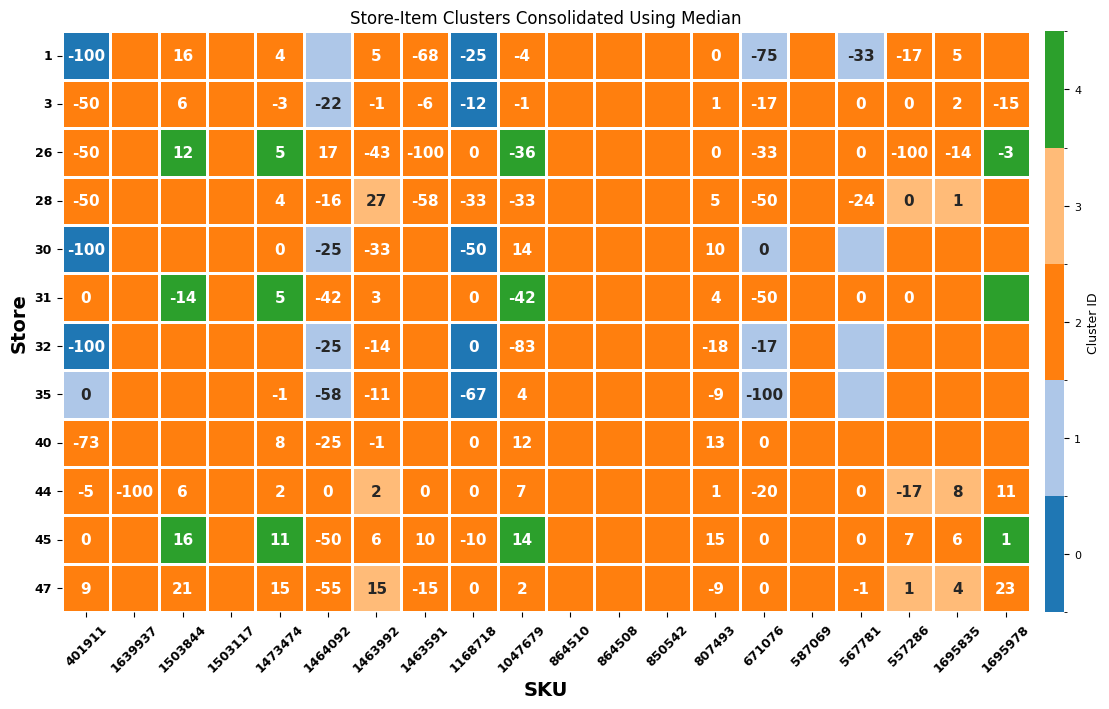

In [45]:
fn = Path("../output/figures/store_item_Jan_2014_median_aggregated_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-Item Clusters Consolidated Using Median",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)

In [46]:
# 1) make a (I×J) block-id matrix aligned to norm_data
bid_mat = (df2
           .pivot(index="store", columns="item", values="block_id")
           .reindex(index=norm_data.index, columns=norm_data.columns)
           .to_numpy())

# 2) pack it in a dict like assign_unique_blocks() returns
assign2 = {"block_id": bid_mat}

# 3) call your existing explain_blocks
summary = est.explain_blocks(
    X=norm_data2.to_numpy(),
    assign=assign2,               # <-- dict with block_id matrix
    row_names=norm_data.index.to_numpy(),
    col_names=norm_data.columns.to_numpy(),
    top_k=5,
)
summary

,block_id,r,c,B_rc,n_cells,coverage_%,mean,median,stores_in_r,items_in_c
4,4,0,4,1.216837,12,5.000000,73.737111,52.351386,"[3, 40]","[401911, 567781, 671076, 1464092]"
3,3,0,3,0.244778,9,3.750000,57.539447,15.917028,"[3, 40]","[401911, 1168718]"
1,1,0,1,-0.142181,14,5.833333,-8.400756,-5.729167,"[3, 40]","[587069, 807493, 850542, 864508, 864510]"
0,0,0,0,-0.392436,8,3.333333,-36.326004,-33.311404,"[3, 40]","[557286, 1463992, 1695835]"
2,2,0,2,-0.470107,197,82.083333,14.840881,0.000000,"[3, 40]","[1047679, 1473474, 1503844, 1695978]"


In [29]:
# Your data as a list of lists
data = [
    [39, 43, 4, 9, 14, 10, 14],
    [45, 58, 6, 12, 16, 7, 13],
    [1, 14, 3, 64, 21, 11, 15],
    [51, 49, 5, 11, 2, 0, 0],
    [0, 9, 2, 56, 0, 1, 2]
]

# Column names
columns = [1, 2, 3, 4, 5, 6, 7]

# Row labels
index = [1, 2, 3, 4, 5]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=index)
# Set index name and dtype
df.index = df.index.astype("int64")  # ensure dtype
df.index.name = "store"              # set name

# Set columns dtype and name
df.columns = df.columns.astype("int64")  # ensure dtype
df.columns.name = "item"                 # set name
df

item,1,2,3,4,5,6,7
store,,,,,,,
1,39,43,4,9,14,10,14
2,45,58,6,12,16,7,13
3,1,14,3,64,21,11,15
4,51,49,5,11,2,0,0
5,0,9,2,56,0,1,2


In [30]:

# always coerce to float
X = df.to_numpy(dtype=np.float64)

est = BinaryTriFactorizationEstimator(
    n_row_clusters=2,         # try a few values (e.g., 3–8)
    n_col_clusters=3,
    k_row=None,               # no cap → multi-hard chosen by data
    k_col=None,
    loss="gaussian",
    alpha=1e-2,               # ridge on B for stability
    beta=0.4,                 # >0 makes memberships sparser
    block_l1=0.1,             # 0 = off; >0 = L1 on B (0.01 = good start)
    b_inner=15,               # inner prox steps for B when block_l1>0
    max_iter=60,
    tol=1e-5,
    random_state=42,
    verbose=False,
).fit(X)



In [31]:
#assign = est.filter_blocks(X= df.to_numpy(), min_keep=10)
mask   = est.allowed_mask_from_gap(min_keep=5)   # aim for ~5 colors
assign = est.assign_unique_blocks(X= X, method="gaussian_delta",
                                  allowed_mask=mask, on_empty="fallback")
block_id = assign["block_id"]  # (I×J), each cell → one color
df2 = get_normalized_assignments(assign, df)

2025-09-03 14:23:16,234 - INFO - Saving plot to ../output/figures/store_item_toy_data_heatmap.tiff


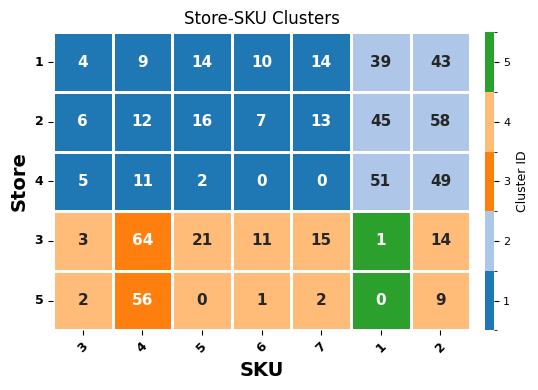

In [32]:
row_order, col_order = est.get_row_col_orders(assign, df)
fn = Path("../output/figures/store_item_toy_data_heatmap.tiff")
plot_block_annot_heatmap(
    df2,
    ttl="Store-SKU Clusters",
    value_col="growth_rate_1", 
    block_col="block_id",
    row_col="store", 
    col_col="item",
    date_col=None,                
    row_order=row_order, 
    col_order=col_order,
    fmt= "{:.0f}",
    cell_h=0.6, 
    cell_w=0.75, 
    font_size=11,
    #figsize=(6, 4),
    x_label="SKU",
    y_label="Store",
    xlabel_size=14,
    ylabel_size=14,
    label_weight="bold",
    fn=fn,
    xtick_rotation=45,
)

In [63]:
_,B, _ = est.factors()

In [61]:
B

array([[ 3.15697981e-02,  9.03453984e+00,  3.69419166e+01],
       [ 3.58255071e+01,  1.08060348e+01, -4.99623999e+00]])

In [54]:
est.compute_tss_rss_pve(X=X, baseline="grand_mean")

{'tss': 12941.885714285712,
 'rss': 1706.043127810404,
 'pve': 86.81766192752565,
 'baseline': 'grand_mean'}

In [17]:
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_spectral.parquet")
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq = "W",
    model_name="SpectralBiclustering", # SpectralCoclustering, SpectralBicclustering,
    row_range = range(2, 5),
    col_range = range(2, 5),
    only_best_model = True,
    only_top_n_clusters = 2,
    min_cluster_size = 2,
    skip_invalid = True,
)

2025-08-22 10:04:27,901 - INFO - Number of items: 20
2025-08-22 10:04:27,902 - INFO - Number of stores: 12
2025-08-22 10:04:27,903 - INFO - Building model SpectralBiclustering with n_row=2, n_col=2


2025-08-22 10:04:28,139 - ERROR - [FAIL] n_row=2, n_col=2 → 
2025-08-22 10:04:28,141 - INFO - Building model SpectralBiclustering with n_row=2, n_col=3
2025-08-22 10:04:28,251 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,251 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,252 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,253 - INFO - [col clusters] expected=3; present=3
2025-08-22 10:04:28,254 - INFO -   - Cluster 0: 16 members
2025-08-22 10:04:28,254 - INFO -   - Cluster 1: 3 members
2025-08-22 10:04:28,255 - INFO -   - Cluster 2: 1 members
2025-08-22 10:04:28,255 - WARNING - [skip] n_row=2, n_col=3: rows<2=[] cols<2=[2]
2025-08-22 10:04:28,256 - INFO - Building model SpectralBiclustering with n_row=2, n_col=4
2025-08-22 10:04:28,385 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:04:28,385 - INFO -   - Cluster 0: 7 members
2025-08-22 10:04:28,386 - INFO -   - Cluster 1: 5 members
2025-08-22 10:04:28,387 - INFO - [col clusters] expected=4

In [16]:
# Example with custom GDKM parameters
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_gdkm.parquet")
model_kwargs={
        'max_iter': 200,
        'tol': 1e-5,
        'random_state': 123,
        'norm': 'mav_ratio'  # Try L1 norm instead of L2
    }
 
df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="GeneralizedDoubleKMeans",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)

2025-08-22 10:03:59,239 - INFO - Number of items: 20
2025-08-22 10:03:59,240 - INFO - Number of stores: 12
2025-08-22 10:03:59,241 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=2
2025-08-22 10:03:59,242 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,246 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:03:59,246 - INFO -   - Cluster 0: 1 members


2025-08-22 10:03:59,247 - INFO -   - Cluster 1: 11 members
2025-08-22 10:03:59,247 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:03:59,248 - INFO -   - Cluster 0: 16 members
2025-08-22 10:03:59,249 - INFO -   - Cluster 1: 4 members
2025-08-22 10:03:59,249 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:03:59,250 - INFO - Building model GeneralizedDoubleKMeans with n_row=2, n_col=3
2025-08-22 10:03:59,251 - INFO - Initialized with norm=mav_ratio, stats=mean
2025-08-22 10:03:59,346 - INFO - No column clustering detected.
2025-08-22 10:03:59,347 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:03:59,347 - INFO - Biclustering with column detected.
2025-08-22 10:03:59,348 - INFO - TSS:97.0188764796087,RSS:72.77858219132492, PVE%:24.98513193293739
2025-08-22 10:03:59,349 - INFO - PVE row-only: 56.53%  |  PVE block: 24.99%
2025-08-22 10:03:59,356 - INFO - Model: GeneralizedDoubleKMeans(n_row_clusters=2, n_col_clus

In [9]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [15]:

model_kwargs={
    'huber_delta': 1.0,
    'alpha_empty': 200.0,
    'alpha_var': 10,
    'solver': 'batch',
    'tie_breaker': "balance",
    'track_objective': 'l1',
    'use_trace': False,
    'row_batch': 256,
    'col_batch': 256,
    'online_steps': 200,
    'max_iter': 200,
    'tol': 1e-5,
    'random_state': 123,
    'norm': 'l1',  # Try L1 norm instead of L2
}
only_best_model_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.csv")
only_top_n_clusters_path = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm_top_2.csv")
df_fn = Path("../output/data/train_2014_January_12_store_20_item_cluster_solver_gdkm.parquet")

df2 = cluster_data(
    df,
    mav_df_fn = df_fn,
    only_best_model_path = only_best_model_path,
    only_top_n_clusters_path = only_top_n_clusters_path,
    freq="W", 
    min_cluster_size = 2,
    skip_invalid = True,
    model_name="TiedGDKM",
    row_range=range(2, 4),  # Try 2-3 row clusters
    col_range=range(2, 4),  # Try 2-3 column clusters  
    model_kwargs=model_kwargs,
)


2025-08-22 10:01:04,589 - INFO - Number of items: 20
2025-08-22 10:01:04,590 - INFO - Number of stores: 12
2025-08-22 10:01:04,591 - INFO - Building model TiedGDKM with n_row=2, n_col=2
2025-08-22 10:01:04,596 - INFO - [row clusters] expected=2; present=2
2025-08-22 10:01:04,597 - INFO -   - Cluster 0: 1 members
2025-08-22 10:01:04,597 - INFO -   - Cluster 1: 11 members
2025-08-22 10:01:04,598 - INFO - [col clusters] expected=2; present=2
2025-08-22 10:01:04,599 - INFO -   - Cluster 0: 16 members
2025-08-22 10:01:04,600 - INFO -   - Cluster 1: 4 members
2025-08-22 10:01:04,600 - WARNING - [skip] n_row=2, n_col=2: rows<2=[0] cols<2=[]
2025-08-22 10:01:04,601 - INFO - Building model TiedGDKM with n_row=2, n_col=3
2025-08-22 10:01:04,739 - INFO - No column clustering detected.
2025-08-22 10:01:04,740 - INFO - TSS:97.0188764796087,RSS:42.17348368760749, PVE%:56.530641027912274
2025-08-22 10:01:04,741 - INFO - Biclustering with column detected.
2025-08-22 10:01:04,741 - INFO - TSS:97.018876

In [23]:
df2["store_cluster"].nunique()

3

In [24]:
df2["item_cluster"].nunique()

3

In [25]:
df2.head()

,date,store_item,store,item,weight,onpromotion,unit_sales,store_cluster,item_cluster,cluster
0,2014-01-01,1_1047679,1,1047679,1,False,0.0,2,1,2_1
1,2014-01-01,1_1168718,1,1168718,1,False,0.0,2,0,2_0
2,2014-01-01,1_1463591,1,1463591,1,False,0.0,2,0,2_0
3,2014-01-01,1_1463992,1,1463992,1,False,0.0,2,2,2_2
4,2014-01-01,1_1464092,1,1464092,1,False,0.0,2,0,2_0


In [13]:

def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return (
        df.groupby(group_column)
        .agg({n_col: "sum"})
        .sort_values(n_col, ascending=False)
        .head(top_n)
    )


In [9]:
# Select top-M items globally
df_top_items = top_n_by_m(
    df, n_col="unit_sales", group_column="item", top_n=9000
)
valid_items = df_top_items.reset_index()["item"].tolist()
print(len(valid_items))
# Select top-N stores globally
df_top_stores = top_n_by_m(
    df, n_col="unit_sales", group_column="store", top_n=51
)
valid_stores = df_top_stores.reset_index()["store"].tolist()
print(len(valid_stores))
unique_dates = df["date"].dropna().unique()
grid = pd.MultiIndex.from_product(
    [valid_stores, valid_items, sorted(unique_dates)],
    names=["store", "item", "date"],
    ).to_frame(index=False)

4036
51


In [4]:
df.to_csv("../data/20250707_train.csv", index=False)

In [4]:
train_df["onpromotion"].unique()

array([nan, False, True], dtype=object)

In [5]:
def top_n_by_m(df, n_col="unit_sales", group_column="store_nbr", top_n=10):
    """
    Returns the top N stores by total unit sales.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        n_col (str): Column representing sales values.
        group_column (str): Column to group by (e.g., store number).
        top_n (int): Number of top results to return.

    Returns:
        pd.DataFrame: DataFrame of top N stores by total sales.
    """
    return df.groupby(group_column).agg({n_col: "sum"}).sort_values(n_col, ascending=False).head(top_n)

def top_values_with_percentage(df, group_column, value_column, n=5):
    """
    Returns the top N values with percentages for each group in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        group_column (str): The column to group by.
        value_column (str): The column to calculate percentages from.
        n (int): The number of top values to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top N values and their percentages for each group.
    """
    grouped = df.groupby(group_column)[value_column].value_counts(normalize=True) * 100
    grouped = grouped.rename('percentage').reset_index()
    top_n = grouped.groupby(group_column).apply(lambda x: x.nlargest(n, 'percentage')).reset_index(drop=True)
    return top_n


def value_counts_with_percentage(df, column_name, top_n = 10):
    """
    Computes value counts and percentage distribution of a column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column_name (str): Name of the column to analyze.

    Returns:
        pd.DataFrame: DataFrame with counts and percentages.
    """
    counts = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize=True) * 100
    df = pd.DataFrame({column_name + '_count': counts, column_name + '_percentage': percentages})
    return df.sort_values(column_name, ascending=False).head(top_n)

In [6]:
df = top_n_by_m(train_df, n_col="unit_sales", group_column="store_nbr", top_n=100)

In [7]:
df

,unit_sales
store_nbr,
44,62087544.00
45,54498012.00
47,50948308.00
3,50481900.00
49,43420088.00
46,41896052.00
48,35933132.00
51,32911484.00
8,30491336.00


In [8]:
# df.reset_index().to_excel(
#     "../output/data/20250627_top_100_store_sale.xlsx",
#     index=False
# )


In [9]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_stores = df.reset_index()["store_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df[ train_df["store_nbr"].isin(valid_stores) ]


In [10]:
train_df_filtered = train_df_filtered.reset_index()
train_df_filtered.drop(["index"], axis=1, inplace=True)

In [11]:
train_df_filtered.head(4)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN


In [19]:
train_df_filtered["store_nbr"].nunique()

54

In [20]:
#top_values_with_percentage(train_df_filtered, "store_nbr", "unit_sales")

In [14]:
def count_percent(series, n=3):
    counts = series.value_counts().head(n)
    percentages = counts / series.count() * 100
    result = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    return result

In [15]:
count_percent(train_df["item_nbr"], n=10)

,Count,Percentage
item_nbr,,
502331,83475,0.066516
314384,83450,0.066496
364606,83308,0.066382
265559,83047,0.066174
559870,82513,0.065749
1036689,82134,0.065447
273528,82108,0.065426
564533,82086,0.065409
261052,81774,0.065160


In [16]:
len(train_df_filtered)

125497040

In [17]:
# assuming df.reset_index()["store_nbr"] gives you the list of valid stores:
valid_item = count_percent(train_df_filtered["item_nbr"], n=500).reset_index()["item_nbr"].tolist()

# Filter train_df to only rows whose store_nbr is in that list:
train_df_filtered = train_df_filtered[ train_df_filtered["item_nbr"].isin(valid_item) ]
train_df_filtered.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
5,5,2013-01-01,25,108786,3.0,NaN
6,6,2013-01-01,25,108797,1.0,NaN
7,7,2013-01-01,25,108952,1.0,NaN
8,8,2013-01-01,25,111397,13.0,NaN
9,9,2013-01-01,25,114790,3.0,NaN


In [29]:
len(train_df_filtered)

34824868

In [19]:
print(train_df_filtered["store_nbr"].nunique())
print(train_df_filtered["item_nbr"].nunique())

54
500


In [20]:
 # Save to a new CSV
 
train_df_filtered.to_csv(
    "../output/data/20250630_train_top_store_500_item.csv",
    index=False
)

In [7]:
train_df["date"] = pd.to_datetime(train_df["date"])
min_date = train_df['date'].min()
cutoff_date = min_date + pd.Timedelta(days=90)

# 3. Filter to the first 30 days
first_n_days = train_df[
    (train_df['date'] >= min_date) &
    (train_df['date'] <= cutoff_date)
].copy()

# 4. (Optional) Sort if you want chronological order
first_n_days.sort_values(['date', 'store_nbr', 'item_nbr'], inplace=True)

In [8]:
first_n_days.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [9]:
first_n_days.reset_index(drop=True, inplace=True)

In [10]:
first_n_days["date"].unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-06 00:00:00',
 '2013-01-07 00:00:00', '2013-01-08 00:00:00', '2013-01-09 00:00:00',
 '2013-01-10 00:00:00', '2013-01-11 00:00:00', '2013-01-12 00:00:00',
 '2013-01-13 00:00:00', '2013-01-14 00:00:00', '2013-01-15 00:00:00',
 '2013-01-16 00:00:00', '2013-01-17 00:00:00', '2013-01-18 00:00:00',
 '2013-01-19 00:00:00', '2013-01-20 00:00:00', '2013-01-21 00:00:00',
 '2013-01-22 00:00:00', '2013-01-23 00:00:00', '2013-01-24 00:00:00',
 '2013-01-25 00:00:00', '2013-01-26 00:00:00', '2013-01-27 00:00:00',
 '2013-01-28 00:00:00', '2013-01-29 00:00:00', '2013-01-30 00:00:00',
 '2013-01-31 00:00:00', '2013-02-01 00:00:00', '2013-02-02 00:00:00',
 '2013-02-03 00:00:00', '2013-02-04 00:00:00', '2013-02-05 00:00:00',
 '2013-02-06 00:00:00', '2013-02-07 00:00:00', '2013-02-08 00:00:00',
 '2013-02-09 00:00:00', '2013-02-10 00:00:00', '2013-02-11 00:00:00',
 '20

In [11]:
 # Save to a new CSV
first_n_days.to_csv(
    "./data/train_first_90_days.csv",
    index=False
)

print(f"Kept records from {min_date.date()} to {cutoff_date.date()} – {len(first_n_days)} rows saved.")


Kept records from 2013-01-01 to 2013-04-01 – 3738322 rows saved.


In [12]:
train_df.groupby(["store_nbr","item_nbr"]).agg({"id":"count"})

id
store_nbr item_nbr      
1         96995      187
          99197      185
          103520    1119
          103665    1358
          105574    1546
...                  ...
54        2110456     47
          2113343      8
          2113914     36
          2116416     11
          2124052      1

[174685 rows x 1 columns]

In [13]:
train_df["item_nbr"].nunique()

4036

In [14]:
train_df["store_nbr"].nunique()

54

In [15]:
train_df.shape

(125497040, 6)

In [16]:
train_df.groupby("store_nbr").agg({"unit_sales":"sum"}).sort_values("unit_sales",ascending=False).head(10)

,unit_sales
store_nbr,
44,62087544.0
45,54498012.0
47,50948308.0
3,50481900.0
49,43420088.0
46,41896052.0
48,35933132.0
51,32911484.0
8,30491336.0


In [9]:
top_n_by_m(train_df)

,unit_sales
store_nbr,
3,24060.347656
8,14659.328125
6,13520.485352
7,11997.501953
5,10598.619141
2,10266.718750
4,10200.083984
9,9757.633789
1,7417.147949


In [11]:
value_counts_with_percentage(train_df, "item_nbr")

,item_nbr_count,item_nbr_percentage
item_nbr,,
165718,10,0.10
103665,10,0.10
165705,10,0.10
165704,10,0.10
115267,10,0.10
...,...,...
268446,1,0.01
279125,1,0.01
302824,1,0.01


In [13]:
df = train_df.groupby("date")["unit_sales"].sum().reset_index()  # Aggregate daily sales

In [14]:
df.shift(5)

,date,unit_sales
0,None,NaN
1,None,NaN
